# Modelo de Tópicos - Latent Dirichlet Allocation

## Motivación

Los __modelos de tópicos__ permiten descubrir, a partir de los propios textos, el conjunto de tópicos o temas que estos abordan. Se trata de un análisis automatizado, que sería muy difícil de llevar a cabo manualmente por personas, debido a la cantidad y tamaño de los textos.

- Revisar el artículo "Probabilistic Topic Models" : https://drive.google.com/open?id=1rSQPJvRVj0V_IChzspQMRPNwlDTkHYHp

Uno de los algoritmos más comunes para aprender modelos de tópicos es el algoritmo _Latent Dirichlet Allocation (LDA)_. LDA modela os textos como provenientes de un modelo generativo, con una estructura oculta de tópicos y distribución de palabras en cada tópico, cuyas distribuciones a priori son Dirichlet.

- Revisar el artículo "Latent Dirichlet Allocation" : https://drive.google.com/file/d/1BobImO3192hifZPLXowd14gryVAUzBPW/view



## ¿Qué hace Latent Dirichlet Allocation?

Dado un número de tópicos definido por el analista, el modelo permite asociar una distribución de tópicos $\theta_d$ a cada texto $d$ y al mismo tiempo, la distribución de palabras $\beta_t$ en cada tópico $t$.

<img src="img/f1.jpg"/>

<img src="img/f2.jpg"/>

## Tutorial práctico

En este tutorial, tomaremos un dataset de posts en un foro en inglés y utilizaremos a LDA para descubrir cuáles son los tópicos conversados.

Utilizaremos la implementación de LDA de la libreria Gensim.

### 1.  Instalación de librerias y depedencias

Utilizaremos en particular:
- la libreria NLTK (Natural Language ToolKit) para tener una lista de "stopwords" del inglés
- el modelo inglés de Spacy para preprocesar los textos y lematizar las palabras
- la librería pyLDAvis que ofrece algunas herramientas de visualización de modelos de tópicos

In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ignacio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/home/ignacio/miniconda3/envs/exp/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### 2. Dataset y preprocessing

El dataset que utilizamos contiene aproximadamente 11.000 posts en el foro newsgroup donde las personas pueden hablar de distintos temas. 

In [3]:
# Import Dataset
df = pd.read_csv('chile_2021-03.csv')
#print(df.target_names.unique())
df.head()

,id,country,media_outlet,url,title,text,date,year,id_journalist
0,12095323,chile,emol,https://www.emol.com/noticias/Economia/2021/03...,"Impuesto a los ""ultra millonarios"": Proyecto d...",Los 100 estadounidenses más ricos entregarían ...,2021-03-01,NaN,NaN
1,12095386,chile,emol,https://www.emol.com/noticias/Economia/2021/03...,El peor Imacec para enero del que se tenga reg...,"Una fuerte contracción de 3,1%, fue la que reg...",2021-03-01,NaN,NaN
2,12095431,chile,emol,https://www.emol.com/noticias/Economia/2021/03...,Millones de empleos menos debido a la pandemia...,#emolmlt-notafotos{float: none; clear: ...,2021-03-01,NaN,NaN
3,12095483,chile,emol,https://www.emol.com/noticias/Economia/2021/03...,"Banco Central dice que ""no debería sorprendern...","El presidente del Banco Central, Mario Marcel...",2021-03-01,NaN,NaN
4,12095526,chile,emol,https://www.emol.com/noticias/Economia/2021/03...,Dólar baja casi $4 este lunes y deja atrás últ...,"El dólar cayó este lunes $3,90 y dejó atrás ...",2021-03-01,NaN,NaN


In [4]:
df.dropna(subset=['text'], inplace=True)

In [5]:
df['text'] = df.text.astype(str)

In [6]:
df.dtypes

id                 int64
country           object
media_outlet      object
url               object
title             object
text              object
date              object
year             float64
id_journalist    float64
dtype: object

In [7]:
df["text"][0]

'Los 100 estadounidenses más ricos entregarían más de US$78.000 millones de sus fortunas personales bajo un impuesto a la riqueza propuesta el lunes por la senadora demócrata Elizabeth Warren y otros legisladores progresistas. Apodada la " Ley de Impuestos a los Ultra Millonarios" , exigiría que los hogares con un patrimonio neto de más de US$50 millones paguen un impuesto anual de 2% de su riqueza, y un impuesto adicional de 1% para las fortunas que excedan los US$ 1.000 millones, aunque es poco probable que la propuesta de Warren avance en un Congreso estrechamente dividido. RelacionadasDetalle(\'1008825\',\'998617\'); Según un análisis de Bloomberg , Jeff Bezos , la persona más rica del mundo, enfrentaría un cargo fiscal adicional de al menos US$5.400 millones en 2021 si el proyecto se convirtiera en ley, mientras que  Elon Musk  pagaría US$ 5.200 millones. En tanto, la medida costaría a  Bill Gates  un adicional de US$4.000 millones y  Mark Zuckerberg  debería que desembolsar más d

In [8]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
#stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [9]:
#stop_words

- Utilizamos expresiones regulares (libreria "re") para suprimir los emails, espacios blancos y caracteres que podrian generan ruido en el análisis.

In [10]:
# Convert to list
data = df.text.values.tolist()
data[0]

'Los 100 estadounidenses más ricos entregarían más de US$78.000 millones de sus fortunas personales bajo un impuesto a la riqueza propuesta el lunes por la senadora demócrata Elizabeth Warren y otros legisladores progresistas. Apodada la " Ley de Impuestos a los Ultra Millonarios" , exigiría que los hogares con un patrimonio neto de más de US$50 millones paguen un impuesto anual de 2% de su riqueza, y un impuesto adicional de 1% para las fortunas que excedan los US$ 1.000 millones, aunque es poco probable que la propuesta de Warren avance en un Congreso estrechamente dividido. RelacionadasDetalle(\'1008825\',\'998617\'); Según un análisis de Bloomberg , Jeff Bezos , la persona más rica del mundo, enfrentaría un cargo fiscal adicional de al menos US$5.400 millones en 2021 si el proyecto se convirtiera en ley, mientras que  Elon Musk  pagaría US$ 5.200 millones. En tanto, la medida costaría a  Bill Gates  un adicional de US$4.000 millones y  Mark Zuckerberg  debería que desembolsar más d

In [11]:
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

data[0]

'Los 100 estadounidenses más ricos entregarían más de US$78.000 millones de sus fortunas personales bajo un impuesto a la riqueza propuesta el lunes por la senadora demócrata Elizabeth Warren y otros legisladores progresistas. Apodada la " Ley de Impuestos a los Ultra Millonarios" , exigiría que los hogares con un patrimonio neto de más de US$50 millones paguen un impuesto anual de 2% de su riqueza, y un impuesto adicional de 1% para las fortunas que excedan los US$ 1.000 millones, aunque es poco probable que la propuesta de Warren avance en un Congreso estrechamente dividido. RelacionadasDetalle(1008825,998617); Según un análisis de Bloomberg , Jeff Bezos , la persona más rica del mundo, enfrentaría un cargo fiscal adicional de al menos US$5.400 millones en 2021 si el proyecto se convirtiera en ley, mientras que Elon Musk pagaría US$ 5.200 millones. En tanto, la medida costaría a Bill Gates un adicional de US$4.000 millones y Mark Zuckerberg debería que desembolsar más de US$ 2.900 mi

- Gensim tiene una función "simple_preprocess" que tokeniza los textos, suprima las puntuaciones y transforma un texto en una lista de tokens

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
data_words = list(sent_to_words(data))

In [13]:
print(data_words[0])

['los', 'estadounidenses', 'mas', 'ricos', 'entregarian', 'mas', 'de', 'us', 'millones', 'de', 'sus', 'fortunas', 'personales', 'bajo', 'un', 'impuesto', 'la', 'riqueza', 'propuesta', 'el', 'lunes', 'por', 'la', 'senadora', 'democrata', 'elizabeth', 'warren', 'otros', 'legisladores', 'progresistas', 'apodada', 'la', 'ley', 'de', 'impuestos', 'los', 'ultra', 'millonarios', 'exigiria', 'que', 'los', 'hogares', 'con', 'un', 'patrimonio', 'neto', 'de', 'mas', 'de', 'us', 'millones', 'paguen', 'un', 'impuesto', 'anual', 'de', 'de', 'su', 'riqueza', 'un', 'impuesto', 'adicional', 'de', 'para', 'las', 'fortunas', 'que', 'excedan', 'los', 'us', 'millones', 'aunque', 'es', 'poco', 'probable', 'que', 'la', 'propuesta', 'de', 'warren', 'avance', 'en', 'un', 'congreso', 'estrechamente', 'dividido', 'segun', 'un', 'analisis', 'de', 'bloomberg', 'jeff', 'bezos', 'la', 'persona', 'mas', 'rica', 'del', 'mundo', 'enfrentaria', 'un', 'cargo', 'fiscal', 'adicional', 'de', 'al', 'menos', 'us', 'millones',

- Para extraer los tópicos de un conjunto de documentos, puede ser muy relevante añadir "conceptos" (palabras de más de 1 token) a nuestro vocabulario. Por lo tanto guardaremos tambien los "bigrams" y "trigrams" más frecuentes.

In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [15]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[16]]])

['alrededor', 'de', 'las', 'horas', 'de', 'este', 'pasado', 'domingo', 'un', 'nino', 'de', 'anos', 'murio', 'por', 'un', 'disparo', 'en', 'medio', 'de', 'un', 'enfrentamiento', 'armado', 'entre', 'carabineros', 'asaltantes', 'en', 'la', 'comuna', 'de', 'maipu', 'en', 'la', 'region_metropolitana', 'segun', 'informacion', 'policial', 'el', 'hecho', 'ocurrio', 'durante', 'una', 'encerrona', 'que', 'afecto', 'una', 'madre', 'que', 'se', 'movilizaba', 'en', 'su', 'vehiculo', 'junto', 'sus', 'hijos', 'raiz', 'de', 'esto', 'desde', 'la', 'fiscalia', 'de', 'alta_complejidad', 'occidente', 'afirmaron', 'que', 'se', 'estan', 'realizando', 'todas', 'las', 'pericias', 'para', 'determinar', 'el', 'origen', 'del', 'disparo', 'lamentablemente', 'el', 'menor', 'se', 'encontraba', 'junto', 'su', 'madre', 'su', 'hermano', 'en', 'las', 'inmediaciones', 'de', 'lugar', 'por', 'razones', 'que', 'se', 'investigan', 'recibio', 'un', 'impacto_balistico', 'el', 'dia', 'de', 'hoy', 'se', 'han', 'realizado', 'div

In [16]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

- Se aplican las funciones para suprimir stopwords, añadir bigrams y lematizar las palabras con los modelos de spacy

In [17]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])
#nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [18]:
print(data_lemmatized[1])

['fuerte', 'contraccion', 'registrar', 'indicador_mensual', 'actividad_economica', 'imacec', 'correspondiente', 'enero', 'mes', 'ano', 'pasar', 'arrancar', 'sorprendio', 'mercar', 'bien', 'retroceso', 'magnitud', 'tratar', 'peor', 'iniciar', 'ano', 'nacional', 'registrar', 'primero', 'publicación', 'imacec', 'partir', 'banco_central', 'comenzar', 'partir', '\ufeff1', 'datar', 'enero', 'doce_meses', 'mas', 'decir', 'indicador_mensual', 'solo', 'caido', 'vez', '\ufeff1', 'mes', 'ano', 'contar', 'justamente', 'caidas', 'grande', 'crisis', 'economicas', 'vivir', 'enero', 'crisis', 'asiatica', 'ir', 'retirar', 'imacec', 'retrocedio', 'mes', 'pleno', 'crisis', 'indicador', 'cayo', 'ver', 'grafico', 'abajar', 'unicas', 'caidas', 'presentar', 'enero', 'historia', 'mas', 'pronunciar', 'dar', 'conocer', 'manana', 'banco_central', 'producto', 'crisis', 'gatillada', 'pandemia', 'economia_lucas', 'destacar', 'resultar', 'crecio', 'diciembre', 'expectativa', 'siguen_siendo', 'positivo', 'ir', 'camin

### 3. Preparar los datos de input de LDA

los datos de input principales de LDA son: un diccionario (id2word) y nuestro dataset preprocesado (data_lemmatized).

In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
id2word

- Se asigna una ID a cada palabra (o concepto) del vocabulario

In [20]:
id2word[0]

'adicional'

In [21]:
# Create Corpus
texts = data_lemmatized

- Se crea una representación "Bag of words" del dataset como input de LDA.

Nota Bene: existen implementaciones de LDA que reciben como input representaciones con "Word Embedding". Ver por ejemplo: https://towardsdatascience.com/combing-lda-and-word-embeddings-for-topic-modeling-fe4a1315a5b4 

In [22]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 3), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 3), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 3), (36, 1), (37, 7), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 3), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 4), (59, 2), (60, 1), (61, 1), (62, 4), (63, 3), (64, 1), (65, 2), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1)]]


In [23]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('adicional', 3),
  ('administrar', 1),
  ('agregar', 1),
  ('alrededor', 1),
  ('alto', 1),
  ('analisis', 2),
  ('anual', 1),
  ('apodar', 1),
  ('aproximadamente', 1),
  ('aumentar', 1),
  ('bezo', 1),
  ('bien', 1),
  ('capturaria', 1),
  ('cargar', 1),
  ('cercar', 1),
  ('congreso', 1),
  ('conservador', 1),
  ('considerar', 1),
  ('costaria', 1),
  ('cubrir', 1),
  ('deberia', 1),
  ('decada', 1),
  ('democratas', 1),
  ('dificil', 1),
  ('disposición', 1),
  ('dividir', 1),
  ('dominar', 1),
  ('empresa', 1),
  ('estadounidense', 3),
  ('estrechamente', 1),
  ('estricto', 1),
  ('exceder', 1),
  ('exigiria', 1),
  ('familia', 1),
  ('fiscal', 1),
  ('fortuna', 3),
  ('ideo', 1),
  ('imponer', 7),
  ('impuesto', 2),
  ('incluir', 1),
  ('informe', 1),
  ('instancia', 1),
  ('juez', 1),
  ('legislador', 1),
  ('ley', 2),
  ('lunes', 1),
  ('mas', 3),
  ('medir', 1),
  ('menos', 1),
  ('millón', 1),
  ('neto', 1),
  ('opositor', 1),
  ('pagar', 2),
  ('pagaria', 1),
  ('personal

### 4. Entrenamiento del modelo de tópico con LDA

- Entrenaremos un primer modelo de tópicos buscando un modelo con 20 tópicos. 

In [24]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### 5. Visualizar los tópicos encontrados

In [25]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics(num_words=25))


[(0,
  '0.077*"empresa" + 0.038*"fabricante" + 0.026*"mercar" + 0.025*"millón" + '
  '0.021*"serbio" + 0.021*"venta" + 0.021*"motor" + 0.017*"sector" + '
  '0.016*"comercial" + 0.016*"comerciar" + 0.015*"producto" + 0.014*"aumentar" '
  '+ 0.013*"consumir" + 0.013*"servicio" + 0.013*"vehiculos_electricos" + '
  '0.013*"vehiculos" + 0.012*"linear" + 0.012*"caida" + 0.011*"actividad" + '
  '0.010*"fabricar" + 0.010*"impactar" + 0.010*"afectar" + 0.010*"automoviles" '
  '+ 0.009*"expectativa" + 0.009*"emplear"'),
 (1,
  '0.033*"ano" + 0.030*"menor" + 0.021*"vehicular" + 0.021*"informar" + '
  '0.015*"hora" + 0.014*"mujer" + 0.013*"trasladar" + 0.011*"ocurrir" + '
  '0.011*"tardar" + 0.011*"hombre" + 0.010*"personal" + 0.009*"servicio" + '
  '0.009*"explicar" + 0.009*"segun" + 0.009*"entregar" + 0.008*"ingresar" + '
  '0.008*"pasajero" + 0.008*"conductor" + 0.008*"trasero" + '
  '0.008*"rendimiento" + 0.008*"hacer" + 0.008*"indicar" + 0.008*"interior" + '
  '0.007*"organismo" + 0.007*"prob

In [26]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/home/ignacio/miniconda3/envs/exp/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.299563  0.077016       1        1  28.883234
7     -0.296029  0.054670       2        1  20.648008
10    -0.236738 -0.053606       3        1  13.339856
5     -0.189365 -0.185679       4        1   6.696659
2     -0.228586  0.261481       5        1   6.047939
1     -0.115425 -0.106805       6        1   5.111765
19     0.004465 -0.079734       7        1   2.751840
16    -0.049681 -0.122075       8        1   2.624201
4     -0.040084  0.166723       9        1   2.541203
0      0.033045 -0.141174      10        1   1.994312
13    -0.013893 -0.132380      11        1   1.982716
18     0.002289  0.097601      12        1   1.715131
9      0.068401 -0.068702      13        1   1.671210
8      0.131052  0.022097      14        1   1.334643
14     0.147247  0.021491      15        1   0.854293
15     0.197188  0.033012      16        1   0.803482
12     0.218992  0.036226      17        1   0.307443
11     0.222234  0.037876      18        1   0.274614
6      0.223842  0.037101      19        1   0.214601
17     0.220610  0.044861      20        1   0.202850, topic_info=             Term         Freq        Total Category  logprob  loglift
416      personar  2703.000000  2703.000000  Default  30.0000  30.0000
1368     elección   893.000000   893.000000  Default  29.0000  29.0000
49         millón  1359.000000  1359.000000  Default  28.0000  28.0000
86            ano  2884.000000  2884.000000  Default  27.0000  27.0000
707          caso  1060.000000  1060.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
4748  reglamentar     0.025667     1.056982  Topic20 -10.2375   2.4825
7429   aeropuerto     0.025667     1.056990  Topic20 -10.2375   2.4825
7539  clandestino     0.025667     1.056997  Topic20 -10.2374   2.4825
3368      estudio     0.025668     1.057053  Topic20 -10.2374   2.4824
3687         edad     0.025667     1.057056  Topic20 -10.2374   2.4824

[1007 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
688      16  0.984919        6
881       3  0.991720   abogar
1350      1  0.994431  abordar
968       1  0.321362    abril
968       2  0.327664    abril
...     ...       ...      ...
280       3  0.085770       ﻿1
280       4  0.037352       ﻿1
280       5  0.226877       ﻿1
280      11  0.012451       ﻿1
280      12  0.074703       ﻿1

[1624 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 8, 11, 6, 3, 2, 20, 17, 5, 1, 14, 19, 10, 9, 15, 16, 13, 12, 7, 18])

### 6. Calcular las metricas de Perplejidad (_Model Perplexity_) y Coherencia (_Coherence Score_)

La perplejidad del modelo y la coherencia del tema proporcionan metricas estadisticas para evaluar que tan revante es un modelo para describir el dataset.

In [27]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.008451470725918

Coherence Score:  0.4862168287379786


### 7. ¿Cómo encontrar cuál es el mejor número de tópicos para describir el dataset?

Buscar el modelo que optimiza la métrica de coherencia (o minimiza la métrica de perplejidad).

In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [29]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=30, step=5)

2
7
12
17
22
27


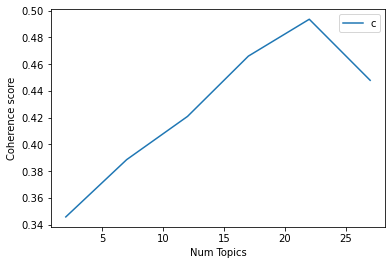

In [30]:
# Show graph
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [42]:
# Print the coherence scores
c=0
bc=c
bv=coherence_values[0]
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    if cv>bv:
        bv=cv
        bc=c
    c+=1
print(bc)

Num Topics = 2  has Coherence Value of 0.3457
Num Topics = 7  has Coherence Value of 0.3885
Num Topics = 12  has Coherence Value of 0.4209
Num Topics = 17  has Coherence Value of 0.466
Num Topics = 22  has Coherence Value of 0.4936
Num Topics = 27  has Coherence Value of 0.4479
4


In [43]:
# Select the model and print the topics

#optimal_model = model_list[4] #elegir manualmente
optimal_model = model_list[bc]



#model_topics = optimal_model.show_topics(formatted=False)
#pprint(optimal_model.print_topics(num_words=10))

In [44]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

/home/ignacio/miniconda3/envs/exp/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.311654  0.106484       1        1  29.878433
3      0.288117  0.133906       2        1  21.293674
10     0.287806 -0.045493       3        1  15.317232
1      0.209928 -0.050617       4        1   7.018314
21     0.203347 -0.154264       5        1   5.113059
9      0.170525 -0.186109       6        1   3.695833
8      0.149302 -0.049183       7        1   3.427379
4      0.119930  0.322310       8        1   3.130712
16     0.024965 -0.037340       9        1   2.053983
14     0.074053 -0.148738      10        1   1.972293
18    -0.015122  0.170878      11        1   1.839668
19    -0.025256 -0.100036      12        1   1.152627
0     -0.095688  0.026444      13        1   1.036837
15    -0.150000  0.012543      14        1   0.915297
5     -0.170417  0.001312      15        1   0.511269
20    -0.188125 -0.014787      16        1   0.394391
2     -0.190540  0.010119      17        1   0.345046
13    -0.185915  0.001780      18        1   0.337443
6     -0.199682  0.001664      19        1   0.315472
17    -0.202328  0.002317      20        1   0.148784
11    -0.208082 -0.001489      21        1   0.061761
12    -0.208473 -0.001700      22        1   0.040493, topic_info=            Term         Freq        Total Category  logprob  loglift
416     personar  2721.000000  2721.000000  Default  30.0000  30.0000
49        millón  1424.000000  1424.000000  Default  29.0000  29.0000
401        nuevo  2131.000000  2131.000000  Default  28.0000  28.0000
55    presidente  1773.000000  1773.000000  Default  27.0000  27.0000
707         caso  1029.000000  1029.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
5011    deportar     0.007718     0.979206  Topic22  -9.8278   2.9686
6224   academico     0.007718     0.979204  Topic22  -9.8278   2.9686
4932      mexico     0.007718     0.979209  Topic22  -9.8278   2.9686
3307     defensa     0.007718     0.979218  Topic22  -9.8278   2.9686
4314     atender     0.007718     0.979204  Topic22  -9.8278   2.9686

[1060 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
688      14  0.979446        6
1641      3  0.993710  acceder
2827      3  0.997089   acceso
74        1  0.140388  acordar
74        2  0.402967  acordar
...     ...       ...      ...
565       5  0.203393     zona
565      11  0.091176     zona
280       1  0.961416       ﻿1
280       3  0.030669       ﻿1
280      12  0.006667       ﻿1

[1424 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 11, 2, 22, 10, 9, 5, 17, 15, 19, 20, 1, 16, 6, 21, 3, 14, 7, 18, 12, 13])

### 8. ¿Cuál es el tópico principal de cada documento?

In [34]:
pd.options.display.max_colwidth = 1000

In [35]:
def format_topics_documents(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_documents(ldamodel=optimal_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10.0,0.6056,"millón, mayor, proyectar, sistema, nuevo, ayudar, mas, personar, aumentar, medir","[estadounidense, mas, rico, fortuna, personal, imponer, riqueza, proponer, lunes, legislador, progresista, apodar, ley, impuesto, ultra, exigiria, neto, pagar, imponer, anual, riqueza, imponer, adicional, fortuna, exceder, probable, proponer, estrechamente, dividir, segun, analisis, bezo, cargar, fiscal, adicional, menos, proyectar, ley, pagaria, medir, costaria, adicional, deberia, cubrir, imponer, estadounidense, mas, rico, agregar, millón, fortuna, segun, capturaria, aumentar, proyectar, incluir, disposición, requisito, mas, estricto, informe, imponer, salir, estadounidense, rico, bien, presidente, proponer, impuesto, alto, empresa, rico, democratas, congreso, imponer, riqueza, opositor, ideo, serio, dificil, administrar, ultimar, instancia, serio, considerar, dominar, juez, conservador, cercar, familia, aproximadamente, terminarian, pagar, imponer, proponer, analisis, recaudaria, alrededor, us_billones, decada]"
1,1,8.0,0.5190,"cobrar, mercar, barrio, crecimiento, nivel, div_nota_tabla_emol, color_linear, alzar, caida, sector","[fuerte, contraccion, registrar, indicador_mensual, actividad_economica, imacec, correspondiente, enero, mes, ano, pasar, arrancar, sorprendio, mercar, bien, retroceso, magnitud, tratar, peor, iniciar, ano, nacional, registrar, primero, publicación, imacec, partir, banco_central, comenzar, partir, ﻿1, datar, enero, doce_meses, mas, decir, indicador_mensual, solo, caido, vez, ﻿1, mes, ano, contar, justamente, caidas, grande, crisis, economicas, vivir, enero, crisis, asiatica, ir, retirar, imacec, retrocedio, mes, pleno, crisis, indicador, cayo, ver, grafico, abajar, unicas, caidas, presentar, enero, historia, mas, pronunciar, dar, conocer, manana, banco_central, producto, crisis, gatillada, pandemia, economia_lucas, destacar, resultar, crecio, diciembre, expectativa, siguen_siendo, positivo, ir, caminar, sostener, titular, exponer, convencer, gradual, actividad_economica, impulsar, inversión, publicar, privar, ...]"
2,2,10.0,0.3346,"millón, mayor, proyectar, sistema, nuevo, ayudar, mas, personar, aumentar, medir","[emolmlt_notafotos, float_none, clear_both, emolmlt_notafotos, background_color, padding, emolmlt_notafotos, img_width, emolmlt_notafotos, background_color, emolmlt_notafotos, emolmlt_notafotos, emolmlt_notafotos, li_div, img_width, px, emolmlt_notafotos, position_absolute, px, px, background_color, emolmlt_notafotos, px, px, efefef, internacional, estimar, aumentar, ano, contraerse, pandemia, obligar, cese, actividad, economista, tasar, crecimiento, podria, subir, aun, casi, billón, dolar, programar, estimular, ano, pasar, incluir, medir, millón, diciembre, clave, ayudar, avanzar, presidente, apoyar, empresa, familia, empleo, estatal, local, presidente, decir, crecimiento, podria, alcanzar, analista, daco, estimar, podria, superar, rapida, suscitar, preocupación, posible, alzar, precio, temor, decir, probable, durar, pico, inflacionario, proximos_meses, comprometio, mantener, bajo, tasar, interes, superar, tiempo, volvera, emplear, medir, empresa, poder, reabrir, adaptarse, nuevo,..."
3,3,8.0,0.4935,"cobrar, mercar, barrio, crecimiento, nivel, div_nota_tabla_emol, color_linear, alzar, caida, sector","[presidente, refirio, tardar, fuerte, caida, anotar, chileno, enero, asegurar, deberia, sorprendernos, recalcar, aun, harto, desafios, caminar, indicador_mensual, actividad_economica, imacec, registrar, retroceso, mes, ubicandose, debajo, expectivas, claro, enero, mes, aumentar, cuarentena, restricción, movilidad, ademar, dias, menos, senalo, economista, entonces, agregar, expectativa, economicas, mesar, caracteristicas, deberia, sorprendernos, importante, velocidad, llevar, economia, destacar, nacional, diciembre, similar, velocidad, crecimiento, mensual, ultimar, trimestre, ano, harto, desafios, precariedad, sector, medio, ingreso, l

In [36]:
df_dominant_topic.head(100)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10.0,0.6056,"millón, mayor, proyectar, sistema, nuevo, ayudar, mas, personar, aumentar, medir","[estadounidense, mas, rico, fortuna, personal, imponer, riqueza, proponer, lunes, legislador, progresista, apodar, ley, impuesto, ultra, exigiria, neto, pagar, imponer, anual, riqueza, imponer, adicional, fortuna, exceder, probable, proponer, estrechamente, dividir, segun, analisis, bezo, cargar, fiscal, adicional, menos, proyectar, ley, pagaria, medir, costaria, adicional, deberia, cubrir, imponer, estadounidense, mas, rico, agregar, millón, fortuna, segun, capturaria, aumentar, proyectar, incluir, disposición, requisito, mas, estricto, informe, imponer, salir, estadounidense, rico, bien, presidente, proponer, impuesto, alto, empresa, rico, democratas, congreso, imponer, riqueza, opositor, ideo, serio, dificil, administrar, ultimar, instancia, serio, considerar, dominar, juez, conservador, cercar, familia, aproximadamente, terminarian, pagar, imponer, proponer, analisis, recaudaria, alrededor, us_billones, decada]"
1,1,8.0,0.5190,"cobrar, mercar, barrio, crecimiento, nivel, div_nota_tabla_emol, color_linear, alzar, caida, sector","[fuerte, contraccion, registrar, indicador_mensual, actividad_economica, imacec, correspondiente, enero, mes, ano, pasar, arrancar, sorprendio, mercar, bien, retroceso, magnitud, tratar, peor, iniciar, ano, nacional, registrar, primero, publicación, imacec, partir, banco_central, comenzar, partir, ﻿1, datar, enero, doce_meses, mas, decir, indicador_mensual, solo, caido, vez, ﻿1, mes, ano, contar, justamente, caidas, grande, crisis, economicas, vivir, enero, crisis, asiatica, ir, retirar, imacec, retrocedio, mes, pleno, crisis, indicador, cayo, ver, grafico, abajar, unicas, caidas, presentar, enero, historia, mas, pronunciar, dar, conocer, manana, banco_central, producto, crisis, gatillada, pandemia, economia_lucas, destacar, resultar, crecio, diciembre, expectativa, siguen_siendo, positivo, ir, caminar, sostener, titular, exponer, convencer, gradual, actividad_economica, impulsar, inversión, publicar, privar, ...]"
2,2,10.0,0.3346,"millón, mayor, proyectar, sistema, nuevo, ayudar, mas, personar, aumentar, medir","[emolmlt_notafotos, float_none, clear_both, emolmlt_notafotos, background_color, padding, emolmlt_notafotos, img_width, emolmlt_notafotos, background_color, emolmlt_notafotos, emolmlt_notafotos, emolmlt_notafotos, li_div, img_width, px, emolmlt_notafotos, position_absolute, px, px, background_color, emolmlt_notafotos, px, px, efefef, internacional, estimar, aumentar, ano, contraerse, pandemia, obligar, cese, actividad, economista, tasar, crecimiento, podria, subir, aun, casi, billón, dolar, programar, estimular, ano, pasar, incluir, medir, millón, diciembre, clave, ayudar, avanzar, presidente, apoyar, empresa, familia, empleo, estatal, local, presidente, decir, crecimiento, podria, alcanzar, analista, daco, estimar, podria, superar, rapida, suscitar, preocupación, posible, alzar, precio, temor, decir, probable, durar, pico, inflacionario, proximos_meses, comprometio, mantener, bajo, tasar, interes, superar, tiempo, volvera, emplear, medir, empresa, poder, reabrir, adaptarse, nuevo,..."
3,3,8.0,0.4935,"cobrar, mercar, barrio, crecimiento, nivel, div_nota_tabla_emol, color_linear, alzar, caida, sector","[presidente, refirio, tardar, fuerte, caida, anotar, chileno, enero, asegurar, deberia, sorprendernos, recalcar, aun, harto, desafios, caminar, indicador_mensual, actividad_economica, imacec, registrar, retroceso, mes, ubicandose, debajo, expectivas, claro, enero, mes, aumentar, cuarentena, restricción, movilidad, ademar, dias, menos, senalo, economista, entonces, agregar, expectativa, economicas, mesar, caracteristicas, deberia, sorprendernos, importante, velocidad, llevar, economia, destacar, nacional, diciembre, similar, velocidad, crecimiento, mensual, ultimar, trimestre, ano, harto, desafios, precariedad, sector, medio, ingreso, l

In [37]:
pd.options.display.max_colwidth = 1000

print(df_dominant_topic[:20]["Text"])

0                                                                            [estadounidense, mas, rico, fortuna, personal, imponer, riqueza, proponer, lunes, legislador, progresista, apodar, ley, impuesto, ultra, exigiria, neto, pagar, imponer, anual, riqueza, imponer, adicional, fortuna, exceder, probable, proponer, estrechamente, dividir, segun, analisis, bezo, cargar, fiscal, adicional, menos, proyectar, ley, pagaria, medir, costaria, adicional, deberia, cubrir, imponer, estadounidense, mas, rico, agregar, millón, fortuna, segun, capturaria, aumentar, proyectar, incluir, disposición, requisito, mas, estricto, informe, imponer, salir, estadounidense, rico, bien, presidente, proponer, impuesto, alto, empresa, rico, democratas, congreso, imponer, riqueza, opositor, ideo, serio, dificil, administrar, ultimar, instancia, serio, considerar, dominar, juez, conservador, cercar, familia, aproximadamente, terminarian, pagar, imponer, proponer, analisis, recaudaria, alrededor, us_billones, de

In [38]:
print(df_dominant_topic[:]["Dominant_Topic"])

0       10.0
1        8.0
2       10.0
3        8.0
4        8.0
        ... 
2615     7.0
2616     7.0
2617     7.0
2618     7.0
2619     7.0
Name: Dominant_Topic, Length: 2620, dtype: float64
